In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py

#math
import numpy as np
import math
import scipy.fftpack
from scipy import signal
import scipy.interpolate
from scipy import integrate
pd.TimeSeries = pd.Series 

#gps
from geopy import distance

#plots
import pylab as plt
import matplotlib.pyplot as plt

In [2]:
df = hp.import_csv("~/data/DesertDataOct/Run01/OctoberRun01Bag01.csv") 
df

,time,_analog_output_data,_trisonica_direction,_trisonica_header_frame_id,_trisonica_header_seq,_trisonica_header_stamp_nsecs,_trisonica_header_stamp_secs,_trisonica_humidity,_trisonica_northsouth,_trisonica_pitch,...,_ublox_gps_fix_position_covariance_2,_ublox_gps_fix_position_covariance_3,_ublox_gps_fix_position_covariance_4,_ublox_gps_fix_position_covariance_5,_ublox_gps_fix_position_covariance_6,_ublox_gps_fix_position_covariance_7,_ublox_gps_fix_position_covariance_8,_ublox_gps_fix_position_covariance_type,_ublox_gps_fix_status_service,_ublox_gps_fix_status_status
0,1.603220e+09,0.671380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.603220e+09,NaN,19.0,NaN,287.0,575581073.0,1.603220e+09,35.599998,-0.15,4.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.603220e+09,0.670128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.603220e+09,0.669503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.603220e+09,0.669816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73438,1.603220e+09,1.201919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73439,1.603220e+09,1.175017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73440,1.603220e+09,NaN,111.0,NaN,12277.0,326195001.0,1.603220e+09,36.200001,-1.37,-3.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73441,1.603220e+09,1.162192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
windname = '/home/flybot/data/DesertDataOct/Run01/OctoberDesert1020_0_wind.hdf5'
odorname = '/home/flybot/data/DesertDataOct/Run01/OctoberDesert1020_0_odor.hdf5'
wd = hp.uncooperative_hdf5(windname)

wd

Dataset contains these keys: 
['trisonica']
Using only the first key:  trisonica


,header_seq,header_stamp_secs,header_stamp_nsecs,header_frame_id,header_stamp,speed,direction,northsouth,westeast,updown,temperature,pitch,roll,pressure,humidity,t_secs,t_nsecs,t
0,287,1603219698,575581073,b'',1.603220e+09,0.94,19.0,-0.15,-0.42,0.83,7.63,4.9,9.9,885.900024,35.599998,1603219698,576224204,1.603220e+09
1,288,1603219698,600331068,b'',1.603220e+09,1.47,27.0,-0.66,-1.30,0.15,7.39,4.9,9.9,885.900024,35.599998,1603219698,600942510,1.603220e+09
2,289,1603219698,625422954,b'',1.603220e+09,1.43,32.0,-0.75,-1.21,0.01,7.62,4.9,9.9,885.900024,35.599998,1603219698,626047771,1.603220e+09
3,290,1603219698,650298118,b'',1.603220e+09,1.44,21.0,-0.52,-1.34,0.12,7.52,4.9,9.9,885.900024,35.599998,1603219698,650777491,1.603220e+09
4,291,1603219698,675504922,b'',1.603220e+09,1.49,17.0,-0.42,-1.40,0.26,7.41,8.3,5.2,885.900024,35.599998,1603219698,675977126,1.603220e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11986,12273,1603219998,226118087,b'',1.603220e+09,1.67,119.0,-1.43,0.80,0.33,7.61,-9.7,1.5,885.700012,36.099998,1603219998,226828451,1.603220e+09
11987,12274,1603219998,251204013,b'',1.603220e+09,1.81,118.0,-1.54,0.82,0.48,7.82,-9.7,1.5,885.700012,36.099998,1603219998,251836811,1.603220e+09
11988,12275,1603219998,276432037,b'',1.603220e+09,1.78,136.0,-1.22,1.28,0.20,7.72,-3.7,-2.1,885.700012,36.200001,1603219998,277147461,1.603220e+09
11989,12276,1603219998,301510095,b'',1.603220e+09,1.65,124.0,-1.36,0.90,0.25,7.61,-3.7,-2.1,885.599976,36.200001,1603219998,302175900,1.603220e+09


In [4]:
time = wd.header_stamp_secs + (wd.header_stamp_nsecs*1e-9)
wd.insert(1 , 'time', time)
wd

,header_seq,time,header_stamp_secs,header_stamp_nsecs,header_frame_id,header_stamp,speed,direction,northsouth,westeast,updown,temperature,pitch,roll,pressure,humidity,t_secs,t_nsecs,t
0,287,1.603220e+09,1603219698,575581073,b'',1.603220e+09,0.94,19.0,-0.15,-0.42,0.83,7.63,4.9,9.9,885.900024,35.599998,1603219698,576224204,1.603220e+09
1,288,1.603220e+09,1603219698,600331068,b'',1.603220e+09,1.47,27.0,-0.66,-1.30,0.15,7.39,4.9,9.9,885.900024,35.599998,1603219698,600942510,1.603220e+09
2,289,1.603220e+09,1603219698,625422954,b'',1.603220e+09,1.43,32.0,-0.75,-1.21,0.01,7.62,4.9,9.9,885.900024,35.599998,1603219698,626047771,1.603220e+09
3,290,1.603220e+09,1603219698,650298118,b'',1.603220e+09,1.44,21.0,-0.52,-1.34,0.12,7.52,4.9,9.9,885.900024,35.599998,1603219698,650777491,1.603220e+09
4,291,1.603220e+09,1603219698,675504922,b'',1.603220e+09,1.49,17.0,-0.42,-1.40,0.26,7.41,8.3,5.2,885.900024,35.599998,1603219698,675977126,1.603220e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11986,12273,1.603220e+09,1603219998,226118087,b'',1.603220e+09,1.67,119.0,-1.43,0.80,0.33,7.61,-9.7,1.5,885.700012,36.099998,1603219998,226828451,1.603220e+09
11987,12274,1.603220e+09,1603219998,251204013,b'',1.603220e+09,1.81,118.0,-1.54,0.82,0.48,7.82,-9.7,1.5,885.700012,36.099998,1603219998,251836811,1.603220e+09
11988,12275,1.603220e+09,1603219998,276432037,b'',1.603220e+09,1.78,136.0,-1.22,1.28,0.20,7.72,-3.7,-2.1,885.700012,36.200001,1603219998,277147461,1.603220e+09
11989,12276,1.603220e+09,1603219998,301510095,b'',1.603220e+09,1.65,124.0,-1.36,0.90,0.25,7.61,-3.7,-2.1,885.599976,36.200001,1603219998,302175900,1.603220e+09


In [5]:
y = []
np.trapz(wd.direction,wd.time)

46234.4161362648

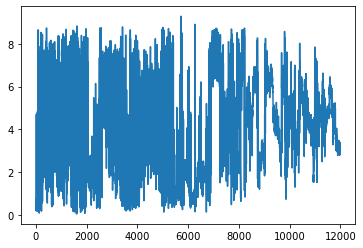

In [6]:
x = []
for i in range(len(wd.direction)-1):
    x.append(np.trapz([wd.direction[i],wd.direction[i+1]],[wd.time[i], wd.time[i+1]]))

fig = plt.figure()
ox = fig.add_subplot(111)
ox.plot(x)


### Stationary Bag B

In [7]:
fname='/home/flybot/data/DesertDataOct/StationeryWind/20201020_172919_windy_b_data.hdf'
wind_df=pd.read_hdf(fname)

In [8]:
wind_df.keys()

Index(['millis', 'lat', 'lon', 'gps_time', 'gps_date', 'wind', 'gps_date_str',
       'year', 'month', 'day', 'gps_time_str', 'hour', 'minute', 'second',
       'time_epoch', 'S2', 'D', 'U', 'V', 'W', 'T', 'H', 'AD', 'MD'],
      dtype='object')

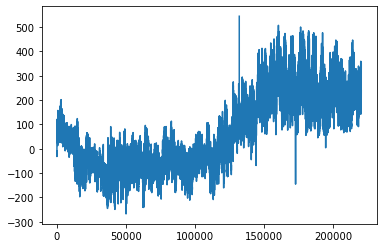

In [9]:
#integration of U vector
y= []
for i in range(len(wind_df.U)-1):
    y.append(np.trapz([wind_df.U[i],wind_df.U[i+1]],[wind_df.millis[i], wind_df.millis[i+1]]))
plt.plot(y)


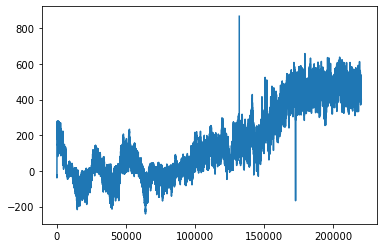

In [10]:
#integration of V vector
z= []
for i in range(len(wind_df.V)-1):
    z.append(np.trapz([wind_df.V[i],wind_df.V[i+1]],[wind_df.millis[i], wind_df.millis[i+1]]))
plt.plot(z)

In [14]:
arr1 =[]
arr2 =[]
for i in range(len(y)):
    if i==0:
        arr1.append(0)
    else:
        arr1.append(y[i]+arr1[i-1])

for i in range(len(z)):
    if i==0:
        arr2.append(0)
    else:
        arr2.append(z[i]+arr2[i-1])

particle = list(zip(arr1, arr2))


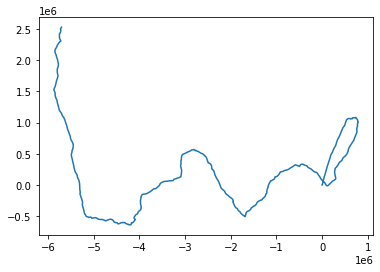

In [12]:
plt.plot(*zip(*particle))

In [26]:
od = hp.uncooperative_hdf5(odorname)
od

Dataset contains these keys: 
['analog_output']
Using only the first key:  analog_output


,data,t_secs,t_nsecs,t
0,0.671380,1603219698,572021154,1.603220e+09
1,0.670128,1603219698,577018085,1.603220e+09
2,0.669503,1603219698,582246585,1.603220e+09
3,0.669816,1603219698,587173698,1.603220e+09
4,0.672631,1603219698,592109752,1.603220e+09
...,...,...,...,...
59948,1.206925,1603219998,312229822,1.603220e+09
59949,1.201919,1603219998,317187629,1.603220e+09
59950,1.175017,1603219998,322268602,1.603220e+09
59951,1.162192,1603219998,327180133,1.603220e+09


In [27]:
time = od.t_secs + (od.t_nsecs*1e-9)
od.insert(1 , 'time', time)
epoch=od.t-od.t[0]
od.insert(2,'epoch',epoch)

In [28]:
od

,data,time,epoch,t_secs,t_nsecs,t
0,0.671380,1.603220e+09,0.000000,1603219698,572021154,1.603220e+09
1,0.670128,1.603220e+09,0.004997,1603219698,577018085,1.603220e+09
2,0.669503,1.603220e+09,0.010225,1603219698,582246585,1.603220e+09
3,0.669816,1.603220e+09,0.015152,1603219698,587173698,1.603220e+09
4,0.672631,1.603220e+09,0.020088,1603219698,592109752,1.603220e+09
...,...,...,...,...,...,...
59948,1.206925,1.603220e+09,299.740209,1603219998,312229822,1.603220e+09
59949,1.201919,1.603220e+09,299.745166,1603219998,317187629,1.603220e+09
59950,1.175017,1.603220e+09,299.750247,1603219998,322268602,1.603220e+09
59951,1.162192,1.603220e+09,299.755159,1603219998,327180133,1.603220e+09


Text(0, 0.5, 'Odor Concentration')

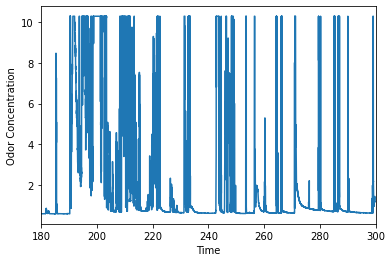

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(od.epoch, od.data)
ax.set_xlim(180,300)
ax.set_xlabel('Time')
ax.set_ylabel('Odor Concentration')

In [ ]:
## TODO: plot odor data where concentration is high and try to fit a line
